In [2]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *

%matplotlib widget
import warnings

data = []

In [3]:
# import backgrounds
paths = glob("../data/2023-12-05*/d*.asc")
paths += glob("../data/2023-12-06*/d*.asc")
paths += glob("../data/2023-12-07*/d*.asc")
paths += glob("../data/2023-12-12*/d*.asc")
paths += glob("../data/2023-12-13*/d*.asc")
paths += glob("../data/2023-12-14*/d*.asc")
paths += glob("../data/2023-12-19*/d*.asc")
paths += glob("../data/2023-12-20*/d*.asc")
paths += glob("../data/2023-12-21*/d*.asc")
paths += glob("../data/2023-12-22*/d*.asc")
paths += glob("../data/2024-01-09*/d*.asc")
paths = [p for p in paths if "bkg" in p]
paths.sort()

import csv

def _read_csv(path):
	rows = []
	with open(path) as f:
		r = csv.reader(f, delimiter="\t")
		for row in r:
			if len(row) == 0:
				return rows
			rows.append(row)
	return rows

def custom_import_spectra(p):
	d = np.array(_read_csv(p))[:, :-1]
	# convert strings to floats
	d = d.astype(float)

	ar = xr.DataArray(
		d[:, 1],
		coords={
			'wavelength': d[:, 0]
		}
	)

	# get the metadata
	number, exposure = p.replace(".", "_").split("s")[0].split("_")[-1].split("x")

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": p.split("data/")[-1].split(".")[0],
		"number": int(number),
		"exposure": float(exposure),
	}
	ar.name = ar.attrs["name"]
	
	return ar

bkg = [custom_import_spectra(p) for p in paths]
bkg_new = bkg.copy()

bkg[0] = bkg[0] / 3
bkg[1] = bkg[1] / 3
bkg[2] = bkg[2] / 5

import difflib

def background_substract_old(sel, b=None):
	if b is np.nan:
		return None
	if b is None:		
		same_folder = [b for b in bkg if sel.name.split("/")[0] in b.name]
		if len(same_folder) == 1: b=same_folder[0]
		elif len(same_folder) > 1:
			b_name = difflib.get_close_matches(sel, [b.name for b in same_folder], n=1, cutoff=0)[0]
			b = [b for b in same_folder if b.name == b_name][0]
		else:
			before = [b for b in bkg if b.name < sel.name]
			if before:
				b = sorted(before, key=lambda x: x.name)[-1]
			else:
				b = sorted(bkg, key=lambda x: x.name)[0]
	
	d =  sel - b.interp(wavelength=sel.wavelength, kwargs={"fill_value": np.nan})
	d.attrs = sel.attrs
	d.name = sel.name
	d.attrs["background"] = b

	d = d.dropna("wavelength")

	d /= d.attrs["number"]
	d /= d.attrs["exposure"]

	return d


bkg = bkg_new

# create a script that
def background_substract(sel, b=None):
	if b is not None:
		return background_substract_old(sel, b)
	
	exposure = sel.attrs["exposure"]
	wavelength = (sel.wavelength.min(), sel.wavelength.max())

	# get all backgrounds with the same exposure
	same_exposure = [b for b in bkg if b.attrs["exposure"] == exposure]

	# find the same wavelength
	same_wavelength = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] and b.wavelength.max() >= wavelength[1]]

	# if there is only one, use it
	if len(same_wavelength) == 1: b=same_wavelength[0]

	# if there are more, use the one with the closest wavelength
	elif len(same_wavelength) > 1:
		b_name = difflib.get_close_matches(sel, [b.name for b in same_wavelength], n=1, cutoff=0)[0]
		b = [b for b in same_wavelength if b.name == b_name][0]
	
	else:
		# check if there is a partial match of the wavelength
		partial_match = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] or b.wavelength.max() >= wavelength[1]]
		if len(partial_match) == 1: b=partial_match[0]
		
		# take the closest one
		elif len(partial_match) > 1:
			# b_name = difflib.get_close_matches(sel, [b.name for b in partial_match], n=1, cutoff=0)[0]
			# b = [b for b in partial_match if b.name == b_name][0]
			b = sorted(partial_match, key=lambda x: np.abs(x.wavelength.mean() - sel.wavelength.mean()))[0]
		
		else:
			warnings.warn(f"no background found for {sel.name}")
			return sel
	
	return background_substract_old(sel, 
		b * sel.attrs["number"] / b.attrs["number"]
	)


pprint([b.name for b in bkg])

['2023-12-05_LO_MG_NiPS3/d001_bkg_15x5s',
 '2023-12-07_LO_MG_NiPS3/d003_bkg_15x5s',
 '2023-12-13_CrPS4_outPlane/d001_bkg_25x5s_horPol',
 '2023-12-14_CrPS4_outPlane/d002_bkg_25x3s',
 '2023-12-14_CrPS4_outPlane/d008_bkg_25x10s',
 '2023-12-20_NiPS3_inPlane/d002_bkg_10x10s',
 '2023-12-20_NiPS3_inPlane/d005_bkg_25x5s_smaller_slit',
 '2023-12-21_NiPS3_inPlane/d001_bkg_10x10s',
 '2023-12-22_NiPS3_inPlane/d001_bkg_5x5s',
 '2024-01-09_NiPS3_inPlane/d002_bkg_5x10s']


# CrPS4

['../data/2023-12-14_CrPS4_outPlane/d003_circExcPol_linDetPol_3x5s_1.5mW.asc',
 '../data/2023-12-14_CrPS4_outPlane/d003_circExcPol_linDetPol_3x5s_3.0mW.asc',
 '../data/2023-12-14_CrPS4_outPlane/d003_circExcPol_linDetPol_3x5s_6.0mW.asc',
 '../data/2023-12-14_CrPS4_outPlane/d003_circExcPol_linDetPol_3x5s_7.1mW.asc',
 '../data/2023-12-14_CrPS4_outPlane/d003_circExcPol_linDetPol_3x5s_4.5mW.asc',
 '../data/2023-12-14_CrPS4_outPlane/d004_circExcPol_linDetPol_5x5s_0.6mW.asc',
 '../data/2023-12-14_CrPS4_outPlane/d004_circExcPol_linDetPol_3x5s_0.6mW.asc',
 '../data/2023-12-14_CrPS4_outPlane/d004_circExcPol_linDetPol_5x5s_0.2mW.asc']


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


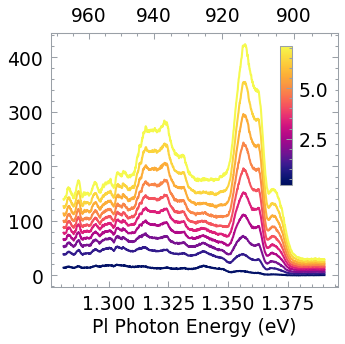

In [4]:
paths = glob("../data/2023-12-14_CrPS4*/d003*.asc")
paths += glob("../data/2023-12-14_CrPS4*/d004*.asc") 

pprint([p for p in paths])

d = [custom_import_spectra(p) for p in paths]
d = [background_substract(d) for d in d]


d = xr.concat(d, dim="power")
d = d.assign_coords(power=[float(p.split("mW")[0].split("_")[-1]) for p in paths])\
.sortby("power")
d = d.drop_duplicates("power")

CrPS4 = d

plt.figure(figsize=(2.5, 2.5))
power = np.linspace(d.power.min(), d.power.max(), 10)
color = cm["CET_L8"](power / power.max())

for p, c in zip(power, color):
	sel = d.interp(power=p)
	sel = sel.rolling(wavelength=3).mean()
	# sel = sel/p
	# sel = d.sel(power=p)
	sel = sel.assign_coords(energy=ev_to_nm(sel.wavelength))
	sel.plot(
		# x="wavelength",
		x="energy",
		color=c,
		label=f"{p} mW",
		_labels={},
	)
# cax = plt.gca().inset_axes([0.05, 0.4, 0.04, 0.55])
cax = plt.gca().inset_axes([0.8, 0.4, 0.04, 0.55])
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=power.min(), vmax=power.max()))
plt.colorbar(sm, cax=cax)


# plt.ylabel("Counts / S / mW")
plt.xlabel("Pl Photon Energy (eV)")
plot.energy_ticks()

# plt.savefig("../figures/2023-12-14 excitation power dependence.png")
# plt.savefig("../report/figures/2023-12-14 CrPS4 excitation power dependence.pdf")

plt.show()

# NiPS3

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


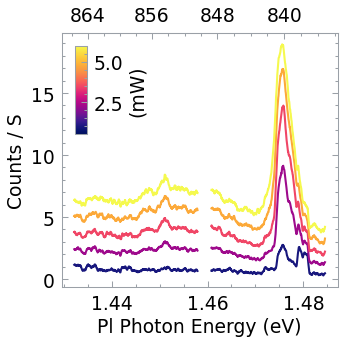

In [5]:
paths = glob("../data/2024-01-18 */d008*.asc")

paths = [p for p in paths if "NiPS3" in p and "mW" in p]


d = [custom_import_spectra(p) for p in paths]
d = [background_substract(d) for d in d]

d = xr.concat(d, dim="power")
d = d.assign_coords(power=[float(p.split("mW")[0].split("_")[-1]) for p in paths])\
.sortby("power")
d = d.drop_duplicates("power")

d -= d.rolling(wavelength=10).mean().min()

NiPS3 = d

plt.figure(figsize=(2.5, 2.5))
# power = np.linspace(d.power.min(), d.power.max(), 5)
power = np.linspace(.5, d.power.max(), 5)
# power = d.power.values
# power = power[::2]
color = cm["CET_L8"](power / power.max())



d = xr.where((d.wavelength > 848.75) & (d.wavelength < 850.25), np.nan, d)

for p, c in zip(power, color):
	sel = d.interp(power=p)
	sel = sel.rolling(wavelength=10).mean()
	# sel = sel/p
	# sel = d.sel(power=p)
	sel = sel.assign_coords(energy=ev_to_nm(sel.wavelength))
	sel.plot(
		# x="wavelength",
		x="energy",
		color=c,
		label=f"{p} mW",
		_labels={},
	)

# plt.legend(loc="upper right")

cax = plt.gca().inset_axes([0.05, 0.6, 0.04, 0.35])
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=power.min(), vmax=power.max()))
plt.colorbar(sm, cax=cax, label="(mW)")

plt.ylabel("Counts / S")
plt.xlabel("Pl Photon Energy (eV)")
plot.energy_ticks()

# plt.savefig("../figures/2024-04-06 NiPS3 excitation power dependence.png")
# plt.savefig("../report/figures/2024-04-06 NiPS3 excitation power dependence.pdf")


plt.show()

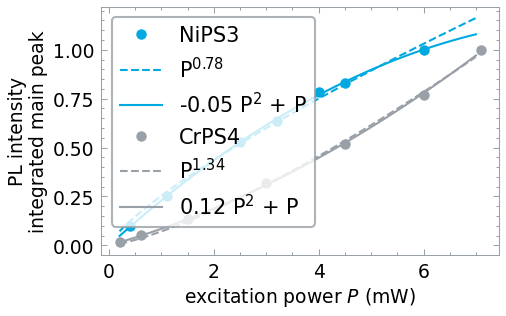

In [6]:
plt.figure(
    # figsize=(5, 2.5),
    figsize=FIGSIZE_MEDIUM
)

def power(x, a, b):
    return a * x**b

def binomial(x, a, b):
    return a*(x + b*x**2)

for sel_raw, l in zip(
    [
        NiPS3.isel(power=slice(1,None)).sel(wavelength=slice(838, 842)), 
        CrPS4.sel(wavelength=slice(907, 917))
    ],
    ["NiPS3", "CrPS4"]
):
    sel = sel_raw
    sel = sel.rolling(wavelength=10).mean()
    # sel = sel.max("wavelength")
    sel = sel.mean("wavelength")
    sel = sel/sel.max()

    # fit exponential model
    p = np.linspace(0.2, 7, 100)


    markers = sel.plot(
        # label=l + f"$\propto P + {10*popt[1]:.2f}\;P^2$", 
        label=l, 
        marker="o", 
        ms=4,
        linestyle="none"
    )
    
    popt, pcov = sp.optimize.curve_fit(power, sel.power, sel, p0=[1, 1])
    plt.plot(p, power(p, *popt),
        "--",
        color=markers[0].get_color(),
        label=f"P$^{{{popt[1]:.2f}}}$"
    )

    popt, pcov = sp.optimize.curve_fit(binomial, sel.power, sel, p0=[1, 1])
    plt.plot(p, binomial(p, *popt),
        "-",
        color=markers[0].get_color(),
        label=f"{popt[1]:.2f} P$^2$ + P"
    )

# plt.xscale("log")
# plt.yscale("log")

# plt.legend(
#     frameon=False, fontsize=FONTSIZE_SMALL, ncol=1,
#     bbox_to_anchor=(1, 1),
#     loc='upper left',
# )

plt.legend(
    frameon=True

)

plt.xlabel("excitation power $P$ (mW)")
plt.ylabel("PL intensity\nintegrated main peak")

plt.tight_layout()

# plt.savefig("../figures/2024-04-19 excitation power dependence of main pl line.png")
# plt.savefig("../report/figures/2024-04-19 excitation power dependence of main pl line.pdf")

plt.show()

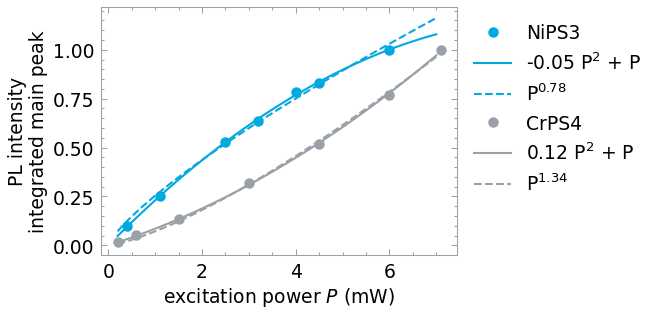

In [11]:
plt.figure(
    figsize=(4.5, FIGSIZE_MEDIUM[1]),
    # figsize=FIGSIZE_MEDIUM
)

def power(x, a, b):
    return a * x**b

def binomial(x, a, b):
    return a*(x + b*x**2)

for sel_raw, l in zip(
    [
        NiPS3.isel(power=slice(1,None)).sel(wavelength=slice(838, 842)), 
        CrPS4.sel(wavelength=slice(907, 917))
    ],
    ["NiPS3", "CrPS4"]
):
    sel = sel_raw
    sel = sel.rolling(wavelength=10).mean()
    # sel = sel.max("wavelength")
    sel = sel.mean("wavelength")
    sel = sel/sel.max()

    # fit exponential model
    p = np.linspace(0.2, 7, 100)


    markers = sel.plot(
        # label=l + f"$\propto P + {10*popt[1]:.2f}\;P^2$", 
        label=l, 
        marker="o", 
        ms=4,
        linestyle="none"
    )

    popt, pcov = sp.optimize.curve_fit(binomial, sel.power, sel, p0=[1, 1])
    plt.plot(p, binomial(p, *popt),
        "-",
        color=markers[0].get_color(),
        label=f"{popt[1]:.2f} P$^2$ + P"
    )
    
    popt, pcov = sp.optimize.curve_fit(power, sel.power, sel, p0=[1, 1])
    plt.plot(p, power(p, *popt),
        "--",
        color=markers[0].get_color(),
        label=f"P$^{{{popt[1]:.2f}}}$"
    )

# plt.xscale("log")
# plt.yscale("log")

plt.legend(
    frameon=False, fontsize=FONTSIZE_SMALL, ncol=1,
    bbox_to_anchor=(1, 1),
    loc='upper left',
)

# plt.legend(
#     frameon=True

# )

plt.xlabel("excitation power $P$ (mW)")
plt.ylabel("PL intensity\nintegrated main peak")

plt.tight_layout()

plt.savefig("../figures/2024-04-19 excitation power dependence of main pl line.png")
plt.savefig("../report/figures/2024-04-19 excitation power dependence of main pl line.pdf")

plt.show()